In [1]:
# Plot HCT + Swift Apparent magnitude Light Curve #
# Import packages and module
#--------------------------------------------------------------------------------#
import os
import re
import glob
import numpy as np
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.ticker import MultipleLocator
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor
#--------------------------------------------------------------------------------#
#%matplotlib widget

In [2]:
# Details of the object under study
#--------------------------------------------------------------------------------#
OBJECT = 'SN2020sck'
OBJECT_RA = '01:10:34.841'
OBJECT_DEC = '+02:06:50.15'
TYPE = 'Iax'
z = 0.017
DISCOVERY_DATE = '2020-08-25 10:03:21.600'
HOST_GALAXY = 'Unknown'
g_max = 59099.139295
B_Jd_max = 2459098.84

#--------------------------------------------------------------------------------#

In [3]:
# Set Directory Structure
#--------------------------------------------------------------------------------#

#SN_directory = '/home/anirban/sn_2017hpa_paper/Results/'  # SN results directory

#SN_data_UBVRI = SN_directory+'OUTPUT_FinalSNMag'
#SN_data_UVOT = SN_directory+'Swift_phot'
#SN_data_lts = SN_directory+'OUTPUT_FinalSNMag1'  # SN data-- late phase template subtracted

FILTER_directory = '/home/anirban/astromatic/'            # Filter information 
FILTER_data = FILTER_directory+'FILTERS.dat'

## MLCS file
#mlcs_dir = '/home/anirban/lc_fit/mlcs2k2.v007/fit/out/'
#mlcs_fit = mlcs_dir+'2017hpa/2017hpa.iter03.obsframe.dat'


SAMPLE_directory = '/home/anirban/Desktop/SNIa_sample/LC_Data/Optical_LC/'   # Sample of SN Ia 
SNdata_df = pd.read_csv(SAMPLE_directory+'TypeIax.dat', sep = '\s+', skiprows=9)
#UVSAMPLE_directory = '/home/anirban/Desktop/SNIa_sample/UV_Data/'
SNdata_df = SNdata_df.set_index('Name')
#SAMPLE_directory_color = '/home/anirban/Desktop/SNIa_sample/LC_Data/New_folder/'
#Lira_file = '/home/anirban/sn_2017hpa_paper/Results/Lira_plot.dat'
#--------------------------------------------------------------------------------#
gri_directory = '/home/anirban/Desktop/SNIa_sample/LC_Data/gri_LC/'
gri_df = pd.read_csv(gri_directory+'TypeIax.dat', sep='\s+', skiprows=9)
gri_df = gri_df.set_index('Name')
#--------------------------------------------------------------------------------#

# Read ZTF light curve
SN_directory = '/home/anirban/2020sck/ZTF_/'               # Results directory
SN_data = SN_directory+'/ZTF20abwrcmq.csv'                 # SN apparent mag (not corrected for
                                                           # k-corr, extinction etc.)
    
SN_directory = '/home/anirban/2020sck_Reduced/Photometry_20210721/'            # SN results directory

SN_data_UBVRI = SN_directory+'OUTPUT_FinalSNMagTemp'

save_results = '/home/anirban/2020sck/Results/'            # Results directory


In [4]:
# Read the filter file containing data on filters 

filter_df = pd.read_csv(FILTER_data, sep = '\s+')
filter_df = filter_df.replace('INDEF', np.nan).set_index(['FILTER', 'Marker', 'Color']).astype('float64')
filter_df = filter_df.reset_index().set_index('FILTER')
list_filters = filter_df.index.tolist()

In [5]:
SNdata_df

B_maximum delta_mB delta_mB_err   EB_V  EB_V_err      D  D_err  \
Name                                                                         
2002cx         415.20     1.70         0.11  0.034     0.005  INDEF  INDEF   
2005hk         685.34     1.68         0.05  0.110     0.005  INDEF  INDEF   
2008ha     2454783.23     2.17         0.02  0.080     0.005  INDEF  INDEF   
2010ae         252.65     2.43         0.20  0.120     0.420   13.1    3.5   
2011ay        5646.60     1.11         0.16  0.081     0.000   86.9    6.9   
2012Z        55965.80     1.43         0.02  0.036     0.030   29.8    3.8   
PS1-12bwh    56224.90    INDEF        INDEF  0.260     0.070  INDEF  INDEF   
2013en       56503.80    INDEF        INDEF  0.500     0.005  INDEF  INDEF   
2014dt       56950.40     1.35         0.06  0.020     0.005  INDEF  INDEF   
2014ck       56845.05     1.76         0.15  0.500     0.100  INDEF  INDEF   
2014ek       56958.39     1.54         0.17  0.054     0.005  INDEF  INDEF   
2015H        57061.90     0.69         0.69  0.048     0.005  60.57   1.95   
2019muj      58707.80      2.4         0.01  0.023     0.005   34.1    2.9   
2019gsc      58638.82     0.91         0.10  0.010     0.005  INDEF  INDEF   

              DM  DM_Err Marker    Color        Data  Source      Epoch  
Name                                                                     
2002cx     35.09    0.32      o  #03071e        BVRI  L03P07  2452000.0  
2005hk     33.46    0.27      p  #6a040f       UBVRI     S08  2453000.0  
2008ha     31.64    0.15      D  #80b918     BVRIJHK    RF09        0.0  
2010ae     30.58    0.58      H  #d00000   BgVrizYJH    SM14  2455000.0  
2011ay     34.70    0.17      o  #fca311   uvw1UBVRI     S15  2450000.0  
2012Z      32.59    0.09      *  #d90429       UVOIR  Y15S15  2450000.0  
PS1-12bwh  34.91    0.15      h  #118ab2        griz    MR17  2450000.5  
2013en     34.11    0.15      X  #073b4c        BVRI   Liu15  2400000.5  
2014dt     30.81    0.20      x  #d90429     BVRIJHK     K18  2400000.5  
2014ck     31.94    0.15      .  #b5179e   uBgVriJHK    TL16  2400000.5  
2014ek     34.99    0.20      P  #003566     BVRIgri    Li18  2400000.5  
2015H      33.91    0.07      o  #582f0e        gVri    MR16  2400000.5  
2019muj    32.66    0.18      d  #1b4332  UVuUBgvrRi    BB21  2400000.5  
2019gsc    33.60    0.02      s  #7400b8       grizy    SS20  2400000.5

In [6]:
# ZTF light curve dataframe

col_names = ['candid_str', 'oid', 'candid', 'JD', 'FILTER', 'diffmaglim', 'FMAG', 'magap', 'FERR',
            'sigmagap', 'ra', 'dec', 'sigmara', 'sigmadec', 'isdiffpos', 'distpsnr1', 'sgscore1', 'field',
            'rcid', 'magnr', 'sigmagnr', 'rb', 'magpsf_corr', 'magap_corr', 'sigmapsf_corr', 'sigmaap_corr',
             'has_stamps', 'parent_candid']
            
ztf_lc_df = pd.read_csv(SN_data, sep = ',', names = col_names, skiprows=1, engine='python')

pd.set_option("display.max_rows", None, "display.max_columns", None)
ztf_lc_df = ztf_lc_df[['JD', 'FILTER', 'FMAG', 'FERR']].copy()

ztf_lc_df['FILTER'] = ztf_lc_df['FILTER'].replace(1, 'g')
ztf_lc_df['FILTER'] = ztf_lc_df['FILTER'].replace(2, 'r')
ztf_lc_df['Phase'] = ztf_lc_df['JD'] - g_max


In [8]:
# Cell that will have all the important functions of the code

def group_similar_files(text_list, common_text, exceptions = ''):
    
    '''
    Remarks: A function to group similar kind of files in a directory.
    text_list: A text file used to store list of files
    common_text: A string (e.g. *.fits, *.list) used for grouping similar
    kinds of files
    exceptions: string of file name to exclude in grouping
    
    returns: list of grouped files
    '''
    
    list_files = glob.glob(common_text)
    if exceptions != '':
        list_exceptions = exceptions.split(',')
        for text in list_exceptions:
            list_files = filter(lambda x: not re.search(text, x), list_files)
        
    list_files.sort()
    if len(text_list) != 0:
        with open(text_list, 'w') as f:
            for file_name in list_files:
                f.write(file_name+'\n')
                
    return list_files   

def plot_params(band, ax, ml_x, mil_x, ml_y, mil_y, invert=False):
    
    '''
    Remarks: Plotting parameters
    ax: axis object
    ml_x: major locator 'x'
    mil_x: minor locator 'x'
    ml_y: major locator 'y'
    mil_y: minor locator 'y'
    invert: Bool for the y-axis to be inverted 
    
    '''
    
    if invert:
        ax.invert_yaxis()
        
    ax.xaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 12, width = 3.0, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 6, width = 1.5, labelsize = 20)
    ax.xaxis.set_major_locator(MultipleLocator(ml_x))
    ax.xaxis.set_minor_locator(MultipleLocator(mil_x))
    ax.yaxis.set_major_locator(MultipleLocator(ml_y))
    ax.yaxis.set_minor_locator(MultipleLocator(mil_y))

def jd_to_date(jd, input_fmt='jd', output_fmt='isot'):
    
    '''
    Remarks: Convert jd to date
    jd: Input jd
    input_fmt: format of input ('jd')
    output_fmt: format of output ('iso', 'isot')
    returns: date
    '''
    
    from astropy.time import Time
    times = Time(jd, format=input_fmt)
    date_time = times.to_value(output_fmt)
    date = date_time.split('T')[0]
    
    return date

def apparent_mag_df(file_name, tempsub=False):
    
    
    '''
    Remarks: Creates an apparent magnitude dataframe
    file_name: file containing the SN magnitudes
    (JD, Filter, FMAG, FERR)
    tempsub: Whether the magnitudes are template subtracted
    returns: apparent magnitude dataframe
    '''
    
    appmag_df = pd.read_csv(file_name, sep = '\s+', engine = 'python', comment='#')
    appmag_df = appmag_df.sort_values(by = ['FILTER', 'JD'], kind = 'mergesort')
    appmag_df = appmag_df[['JD','FILTER', 'FMAG', 'FERR']].reset_index(drop = True)
    
    return appmag_df

def columnwise_to_rowwise(name, data_df):
    
    '''
    Remarks: Change a dataframe in the form of (U,B,V,R,I) to 
    JD, FILTER, FMAG, FERR
    name: Name of the SN
    data_df: dataframe containing the UBVRI magnitudes.
    
    returns: output dataframe containing "Phase, Filter, Fmag, Ferr"
    Updates: Try this in pivot_table.
    '''
    
    ## List of column values to delete from a dataframe
    list_del = ['Date', 'Epoch', 'Seeing', 'JD', 'EXPTIME', 'Y', 'YErr', 'J', 'JErr', 
           'H', 'HErr', 'K', 'KErr', 'g', 'gErr', 'r', 'rErr', 'i', 'iErr', 'Telescope',
               'Unfiltered']
    
    if 'Epoch' in data_df.columns.values:
        data_df['JD'] = data_df['JD'] + data_df['Epoch']
        
    if 'Phase' not in data_df.columns:
        data_df['Phase'] = data_df['JD'] - SNdata_df.loc[name, 'B_maximum']
        
    
    data_df = data_df.set_index('Phase')
    
    for column in list_del:
        if column in data_df.columns.values:
            data_df = data_df.drop(column, axis =1)
            
    data_arr = data_df.values
    size = data_arr.shape
    list_phase = np.repeat(data_df.index.values, (size[1]/2))
    list_filters = [x for x in data_df.columns.values if 'Err' not in x]
    data_arr = np.reshape(data_arr, [int(size[0]) * int(size[1]/2), 2])
    output_df = pd.DataFrame(data_arr, index = list_phase, columns = ['FMAG', 'FERR'])
    output_df.index.name = 'Phase'
    output_df = output_df.reset_index(drop=False)
    output_df['FILTER'] = list_filters * size[0]
    output_df = output_df.replace('INDEF', np.nan).dropna(axis = 0, how = 'any')
    output_df = output_df[['Phase', 'FILTER', 'FMAG', 'FERR']].reset_index(drop =True)
    output_df = output_df.sort_values(by = ['FILTER'], kind = 'mergesort')

    
    return output_df

def columnwise_to_rowwise1(name, data_df):
    
    '''
    Remarks: Change a dataframe in the form of (U,B,V,R,I) to 
    JD, FILTER, FMAG, FERR
    name: Name of the SN
    data_df: dataframe containing the UBVRI magnitudes.
    
    returns: output dataframe containing "Phase, Filter, Fmag, Ferr"
    Updates: Try this in pivot_table.
    '''
    
    ## List of column values to delete from a dataframe
    list_del = ['Date', 'Epoch', 'Seeing', 'Phase', 'JD', 'EXPTIME', 'Y', 'YErr', 'J', 'JErr', 
           'H', 'HErr', 'K', 'KErr', 'Telescope', 'Unfiltered']
    
    if 'Epoch' in data_df.columns.values:
        data_df['JD'] = data_df['JD'] + data_df['Epoch']
        
    if 'Phase' not in data_df.columns:
        data_df['Phase'] = data_df['JD'] - gri_df.loc[name, 'g_maximum']
    #if 'Phase' not in data_df.columns:
    #    data_df['Phase'] = data_df['JD'] - SNdata_df.loc[name, 'B_maximum']
        
    
    data_df = data_df.set_index('Phase')
    #print (data_df)
    
    for column in list_del:
        if column in data_df.columns.values:
            data_df = data_df.drop(column, axis =1)
            
    #print (data_df)
            
    data_arr = data_df.values
    size = data_arr.shape
    list_phase = np.repeat(data_df.index.values, (size[1]/2))
    list_filters = [x for x in data_df.columns.values if 'Err' not in x]
    data_arr = np.reshape(data_arr, [int(size[0]) * int(size[1]/2), 2])
    output_df = pd.DataFrame(data_arr, index = list_phase, columns = ['FMAG', 'FERR'])
    output_df.index.name = 'Phase'
    output_df = output_df.reset_index(drop=False)
    output_df['FILTER'] = list_filters * size[0]
    output_df = output_df.replace('INDEF', np.nan).dropna(axis = 0, how = 'any')
    output_df = output_df[['Phase', 'FILTER', 'FMAG', 'FERR']].reset_index(drop =True)
    output_df = output_df.sort_values(by = ['FILTER'], kind = 'mergesort')

    
    return output_df

def plot_sn_ubvri(df_sn, savefig=False):
    
    '''
    Remarks: Plots the comparison SN
    df_sn: SN dataframe (object under study)
    savefig: Bool, to save figure
    returns: None
    '''
    
    list_files = group_similar_files('', SAMPLE_directory+'/*.asc')
    fig_app = plt.figure(figsize=(15,15))
    plt.rcParams['axes.linewidth'] = 2
    fig_app.subplots_adjust(hspace=0.15, wspace=0.2)
    legend_properties = {'size': 22, 'weight': 'book'}
    
    filters = ['U', 'B', 'V', 'R', 'I']

    for i,j in enumerate(filters, 1):
        ax = fig_app.add_subplot(2,3,i)
        ax.set_xlim(-20,100)
        ax.set_ylim(-1,5)
        if j == 'U':
            ax.set_ylabel(r'mag-mag$_{\rm max}$', fontsize = 30, labelpad=10)
            ax.yaxis.set_label_coords(-0.15, 0)
        plot_params('A', ax, ml_x = 20, mil_x = 4, ml_y = 1, mil_y = 0.1, invert=True)
        ax.xaxis.set_major_locator(MultipleLocator(30))
        ax.xaxis.set_minor_locator(MultipleLocator(10))
        sn_df = df_sn[df_sn['FILTER'] == j].copy()
        sn_df = sn_df.sort_values(by = 'Phase')
        
        ax.set_title(j, fontsize = 25)
    
        for file_name in list_files:
            name = file_name.split('/')[-1].split('.')[0]
            if name in ['2002cx', '2005hk', '2008ha', '2010ae', '2012Z', '2014dt', '2014ek', 
                       '2019muj']:
                data_df = pd.read_csv(file_name, sep = '\s+', comment = '#', engine = 'python')
                if 'FMAG' not in data_df.columns.values:
                #data_df['Phase'] = data_df['JD'] - SNdata_df.loc[name, 'B_maximum']
                    data_df = columnwise_to_rowwise(name, data_df)
                    #data_df.to_csv('/home/anirban/Desktop/SNIa_sample/LC_Data/Save_mlcs/'+name+'.dat', sep=' ', 
                    #          index=True, index_label='FILTER')
                    #print (data_df)
                    df = data_df[data_df['FILTER'] == j].copy()
                    df = df.sort_values(by = 'Phase')
                    df.Phase = pd.to_numeric(df.Phase)
                    df.FMAG = pd.to_numeric(df.FMAG)
                    if name == '2012fr':
                        df['Norm_Mag'] = df['FMAG']- dict_maxmag_12fr[j]
                    else:
                        df['Norm_Mag'] = df['FMAG']- df['FMAG'].min()
                    ax.plot(df['Phase'], df['Norm_Mag'], marker = SNdata_df.loc[name, 'Marker'],
                            label = name+' '+'('+str(SNdata_df.loc[name, 'delta_mB'])+')',
                          c = SNdata_df.loc[name, 'Color'], alpha = 0.8, ls = '')
                else:
                    data_df['Phase'] = data_df['JD'] - SNdata_df.loc[name, 'B_maximum']
                    df = data_df[data_df['FILTER'] == j].copy()
                    df = df.sort_values(by = 'Phase')
                    df.Phase = pd.to_numeric(df.Phase)
                    df.FMAG = pd.to_numeric(df.FMAG)
                    ax.plot(df['Phase'], df['FMAG']-df['FMAG'].min(), marker = SNdata_df.loc[name, 'Marker'], label = name, c = SNdata_df.loc[name, 'Color'],
                       alpha = 0.8, ls = '')
            for tick in ax.xaxis.get_major_ticks():
                tick.label1.set_fontsize(fontsize = 25)
                #tick.label1.set_fontweight('bold')
    
            for tick in ax.yaxis.get_major_ticks():
                tick.label1.set_fontsize(fontsize = 25)
                #tick.label1.set_fontweight('bold')    
                
                
        ax.plot(sn_df['Phase'], sn_df['FMAG']-sn_df['FMAG'].min(), label = '2020sck', mfc='orangered', ms = 12, 
                alpha = 0.7, ls = '', marker = 'o', markeredgecolor='red', markeredgewidth=1.5)
    #ax.legend(fontsize = 20, prop = legend_properties, loc = 'best')
    ax.legend(loc='lower right', bbox_to_anchor=(2.2, 0.09),
                  ncol=1, fancybox=True, shadow=True, fontsize = 22, prop = legend_properties,
             markerscale=2.0)
    ax.set_xlabel('Time since B-band maximum (days)', fontsize = 30, labelpad=7)
    #
    if savefig:
        plt.savefig('/home/anirban/2020sck/Results/Plots/Comparison_2020sck_UBVRI.png', 
                    dpi=300, bbox_inches = 'tight', transparent=False, facecolor='white')
        
def plot_sn_gri(gri_df, savefig=False):
    
    list_files = group_similar_files('', SAMPLE_directory+'/*.asc')
    fig_app = plt.figure(figsize=(20, 15))
    plt.rcParams['axes.linewidth'] = 2
    fig_app.subplots_adjust(hspace=0.15, wspace=0.2)
    legend_properties = {'size': 30, 'weight': 'book'}
    
    filters = ['g', 'r']
    
    for i, j in enumerate(filters, 1):
        ax = fig_app.add_subplot(1, 2, i)
        ax.set_xlim(-20,100)
        ax.set_ylim(-1,5)
        #if j == 'g':
        #    ax.set_ylabel(r'mag-mag$_{max}$', fontsize = 30, labelpad=10)
        #    ax.yaxis.set_label_coords(-0.15, 0)
        plot_params('A', ax, ml_x = 20, mil_x = 5, ml_y = 1, mil_y = 0.1, invert=True)
        ax.xaxis.set_major_locator(MultipleLocator(30))
        ax.xaxis.set_minor_locator(MultipleLocator(10))
        sn_df = gri_df[gri_df['FILTER'] == j].copy()
        sn_df = sn_df.sort_values(by = 'Phase')
        #print (sn_df)
        
        ax.set_title(j, fontsize = 25)
    
        for file_name in list_files:
            name = file_name.split('/')[-1].split('.')[0]
            #print (name)
            if name in ['2010ae_gri', '2014ek_gri', '2015H_gri', '2019muj_gri', '2019gsc_gri']:
                data_df = pd.read_csv(file_name, sep = '\s+', comment = '#', engine = 'python')
                #print (data_df)
                if 'FMAG' not in data_df.columns.values:
                #data_df['Phase'] = data_df['JD'] - SNdata_df.loc[name, 'B_maximum']
                    data_df = columnwise_to_rowwise1(name, data_df)
                    #data_df.to_csv('/home/anirban/Desktop/SNIa_sample/LC_Data/Save_mlcs/'+name+'.dat', sep=' ', 
                    #          index=True, index_label='FILTER')
                    #print (data_df)
                    df = data_df[data_df['FILTER'] == j].copy()
                    df = df.sort_values(by = 'Phase')
                    df.Phase = pd.to_numeric(df.Phase)
                    df.FMAG = pd.to_numeric(df.FMAG)
                    if name == '2012fr':
                        df['Norm_Mag'] = df['FMAG']- dict_maxmag_12fr[j]
                    else:
                        df['Norm_Mag'] = df['FMAG']- df['FMAG'].min()
                    ax.plot(df['Phase'], df['Norm_Mag'], marker = SNdata_df.loc[name[:-4], 'Marker'],
                            label = name[:-4]+' '+'('+str(SNdata_df.loc[name[:-4], 'delta_mB'])+')',
                            c = SNdata_df.loc[name[:-4], 'Color'], alpha = 0.8, ls = '', ms=10)
                else:
                    data_df['Phase'] = data_df['JD'] - SNdata_df.loc[name, 'B_maximum']
                    df = data_df[data_df['FILTER'] == j].copy()
                    df = df.sort_values(by = 'Phase')
                    df.Phase = pd.to_numeric(df.Phase)
                    df.FMAG = pd.to_numeric(df.FMAG)
                    ax.plot(df['Phase'], df['FMAG']-df['FMAG'].min(), marker = SNdata_df.loc[name, 'Marker'], label = name, c = SNdata_df.loc[name, 'Color'],
                       alpha = 0.8, ls = '')
            for tick in ax.xaxis.get_major_ticks():
                tick.label1.set_fontsize(fontsize = 40)
                #tick.label1.set_fontweight('bold')
    
            for tick in ax.yaxis.get_major_ticks():
                tick.label1.set_fontsize(fontsize = 40)
                #tick.label1.set_fontweight('bold')    
                
                
        ax.plot(sn_df['Phase'], sn_df['FMAG']-sn_df['FMAG'].min(), label = '2020sck', mfc='orangered', ms = 12, 
                alpha = 0.7, ls = '', marker = 'o', markeredgecolor='red', markeredgewidth=1.5)
    #ax.legend(fontsize = 20, prop = legend_properties, loc = 'best')
    ax.legend(loc='lower right', bbox_to_anchor=(1.8, 0.11),
                  ncol=1, fancybox=True, shadow=True, fontsize = 30, prop = legend_properties,
             markerscale=2.0)
    #ax.set_xlabel('Time since g-band maximum (days)', fontsize = 30, labelpad=7)
    #
    if savefig:
        plt.savefig('/home/anirban/2020sck/Results/Plots/Comparison_2020sck_gri.png', 
                    dpi=300, bbox_inches = 'tight', transparent=False, facecolor='white')

In [9]:
object_df_UBVRI = apparent_mag_df(SN_data_UBVRI)
object_df_UBVRI['Phase'] = (object_df_UBVRI['JD'] - B_Jd_max)

In [26]:
#object_df_UBVRI

In [10]:
dict_maxmag_z = {'U': 0, 'B': 14.738, 'V': 14.470, 'R': 14.209, 'I': 13.986}

In [11]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

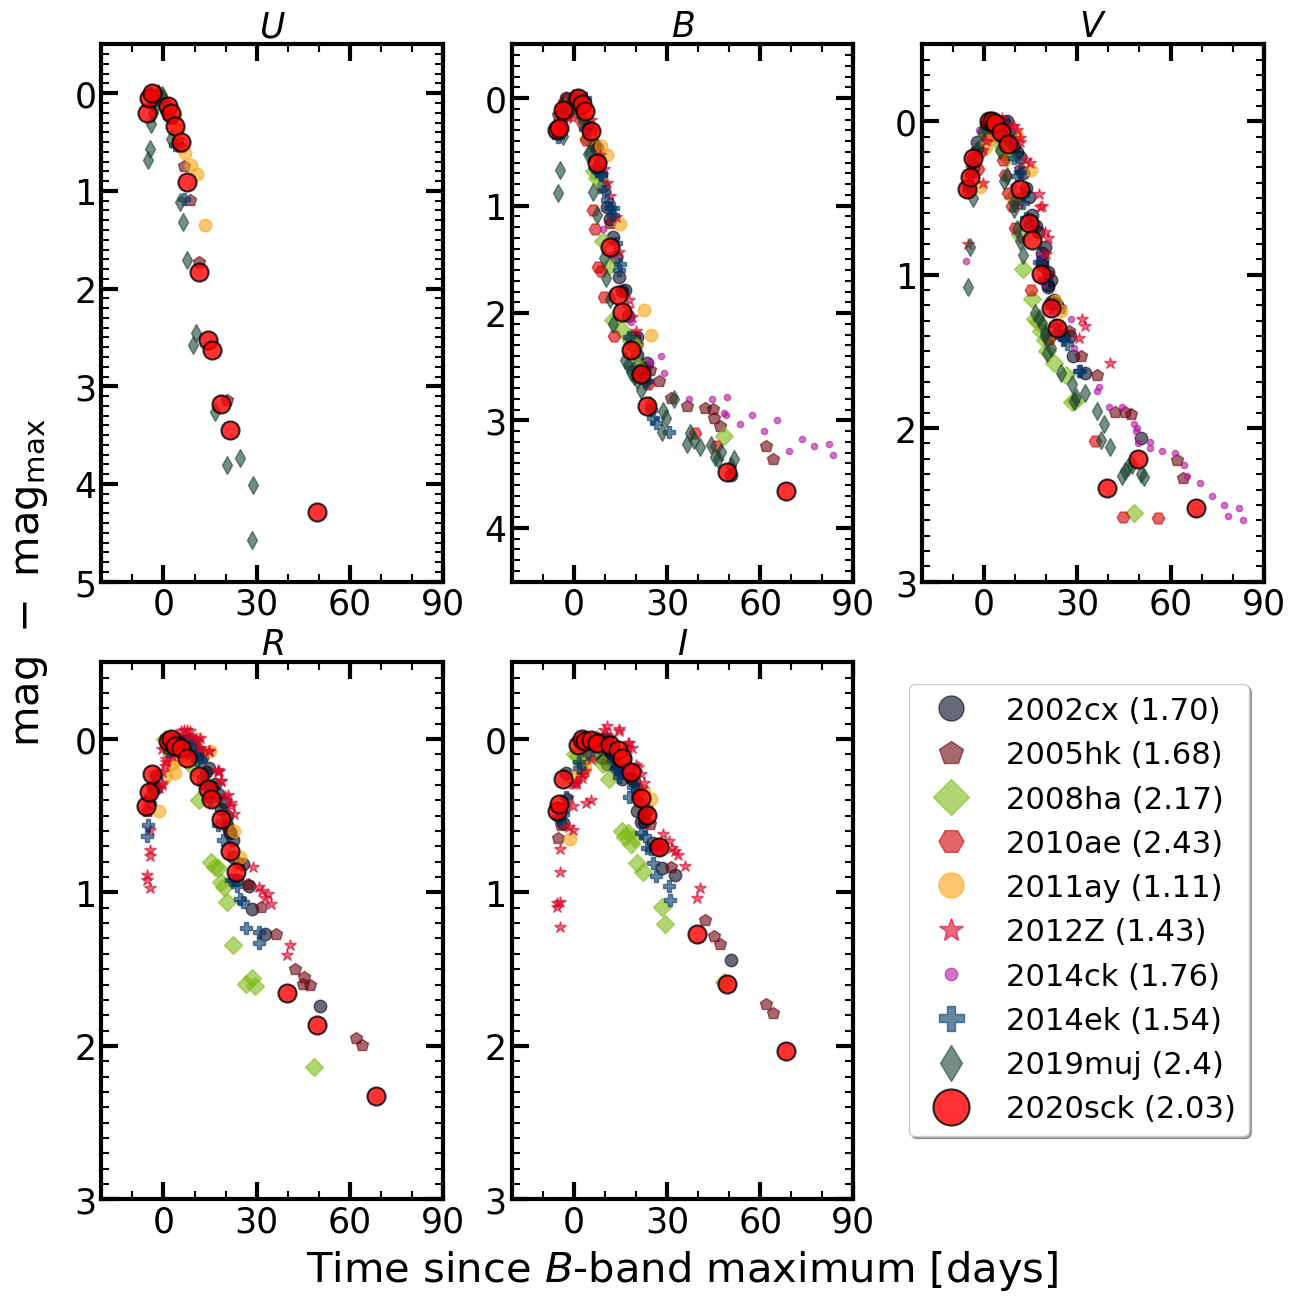

In [12]:
#%matplotlib notebook

def plot_sn_ubvri(df_sn, savefig=False):
    
    '''
    Remarks: Plots the comparison SN
    df_sn: SN dataframe (object under study)
    savefig: Bool, to save figure
    returns: None
    '''
    
    list_files = group_similar_files('', SAMPLE_directory+'/*.asc')
    fig_app = plt.figure(figsize=(15, 15))
    plt.rcParams['axes.linewidth'] = 3
    fig_app.subplots_adjust(hspace=0.15, wspace=0.2)
    legend_properties = {'size': 22, 'weight': 'book'}
    
    filters = ['U', 'B', 'V', 'R', 'I']

    for i,j in enumerate(filters, 1):
        ax = fig_app.add_subplot(2,3,i)
        ax.set_xlim(-20, 90)
        if j == 'U':
            ax.set_ylim(-0.5, 5.0)
        elif j == 'B':
            ax.set_ylim(-0.5, 4.5)
        else:
            ax.set_ylim(-0.5, 3.0)
        if j == 'U':
            ax.set_ylabel(r'$\rm mag\ -\ mag_{max}$', fontsize = 30, labelpad=10)
            ax.yaxis.set_label_coords(-0.15, 0)
        plot_params('A', ax, ml_x = 20, mil_x = 4, ml_y = 1, mil_y = 0.1, invert=True)
        ax.xaxis.set_major_locator(MultipleLocator(30))
        ax.xaxis.set_minor_locator(MultipleLocator(10))
        sn_df = df_sn[df_sn['FILTER'] == j].copy()
        sn_df = sn_df.sort_values(by = 'Phase')
        
        ax.set_title(r'$%s$'%j, fontsize = 25)
    
        for file_name in list_files:
            #print (file_name)
            name = file_name.split('/')[-1].split('.')[0]
            #if name in ['2002cx', '2005hk', '2008ha', '2010ae', '2012Z', '2014dt', '2014ek', 
            #           '2019muj']:
            if name in ['2002cx', '2005hk', '2008ha', '2010ae', '2011ay', '2012Z', '2014ck', '2014ek', '2019muj']:
            #if name in ['2011ay']:
                data_df = pd.read_csv(file_name, sep = '\s+', comment = '#', engine = 'python')
                if 'FMAG' not in data_df.columns.values:
                #data_df['Phase'] = data_df['JD'] - SNdata_df.loc[name, 'B_maximum']
                    data_df = columnwise_to_rowwise(name, data_df)
                    #print (data_df)
                    #data_df.to_csv('/home/anirban/Desktop/SNIa_sample/LC_Data/Save_mlcs/'+name+'.dat', sep=' ', 
                    #          index=True, index_label='FILTER')
                    #print (data_df)
                    df = data_df[data_df['FILTER'] == j].copy()
                    #print (df)
                    df = df.sort_values(by = 'Phase')
                    df.Phase = pd.to_numeric(df.Phase)
                    df.FMAG = pd.to_numeric(df.FMAG)
                    if name == '2012Z':
                        df['Norm_Mag'] = df['FMAG']-dict_maxmag_z[j]
                        #df['Norm_Mag'] = df['FMAG'] - df['FMAG'].min()
                    else:
                        df['Norm_Mag'] = df['FMAG']- df['FMAG'].min()
                        #print (df['FMAG'].min())
                    ax.plot(df['Phase'], df['Norm_Mag'], marker = SNdata_df.loc[name, 'Marker'],
                            label = name+' '+'('+str(SNdata_df.loc[name, 'delta_mB'])+')',
                          c = SNdata_df.loc[name, 'Color'], alpha = 0.6, ls = '', ms=9)
                else:
                    data_df['Phase'] = data_df['JD'] - SNdata_df.loc[name, 'B_maximum']
                    df = data_df[data_df['FILTER'] == j].copy()
                    df = df.sort_values(by = 'Phase')
                    df.Phase = pd.to_numeric(df.Phase)
                    df.FMAG = pd.to_numeric(df.FMAG)
                    ax.plot(df['Phase'], df['FMAG']-df['FMAG'].min(), marker = SNdata_df.loc[name, 'Marker'], label = name, c = SNdata_df.loc[name, 'Color'],
                       alpha = 0.4, ls = '')
            for tick in ax.xaxis.get_major_ticks():
                tick.label1.set_fontsize(fontsize = 25)
                #tick.label1.set_fontweight('bold')
    
            for tick in ax.yaxis.get_major_ticks():
                tick.label1.set_fontsize(fontsize = 25)
                #tick.label1.set_fontweight('bold')    
                
                
        ax.plot(sn_df['Phase'], sn_df['FMAG']-sn_df['FMAG'].min(), label = '2020sck (2.03)', mfc='red', 
                alpha = 0.8, ls = '', marker = 'o', markeredgecolor='black', markeredgewidth=1.5, ms=13)
    #ax.legend(fontsize = 20, prop = legend_properties, loc = 'best')
    ax.legend(loc='lower right', bbox_to_anchor=(2.2, 0.09),
                  ncol=1, fancybox=True, shadow=True, fontsize = 22, prop = legend_properties,
             markerscale=2.0)
    ax.set_xlabel(r'Time since $B$-band maximum [days]', fontsize = 30, labelpad=7)
    #ax.set_xlim(-6, 70)
    #
    if savefig:
        plt.savefig('/home/anirban/2020sck/Results/New_Results/Results/Plots/Comparison_2020sck_UBVRI.png', 
                    dpi=100, bbox_inches = 'tight', transparent=False, facecolor='white')

#===========================================================================================#
plot_sn_ubvri(object_df_UBVRI, savefig=False)
#hk_df['JD'] = hk_df['Phase'].apply(lambda x: x + 2453685.34)
#hk_df['JD'] = pd.to_numeric(hk_df.JD)
#hk_df['Phase'] = pd.to_numeric(hk_df.Phase)
#hk_df['FMAG'] = pd.to_numeric(hk_df.FMAG)
#hk_df['FERR'] = pd.to_numeric(hk_df.FERR)
plt.show();
#print (hk_df)

In [13]:
gri_df

g_maximum delta_mg delta_mB_err   EB_V  EB_V_err      D  D_err  \
Name                                                                         
2002cx         415.20     1.70         0.11  0.034     0.005  INDEF  INDEF   
2005hk         686.00     1.36         0.05  0.110     0.005  INDEF  INDEF   
2008ha     2454783.76     1.80         0.02  0.080     0.005  INDEF  INDEF   
2010ae         253.00     1.51         0.20  0.120     0.420   13.1    3.5   
2011ay        5646.60     1.11         0.16  0.081     0.000   86.9    6.9   
2012Z         5969.78     1.30         0.02  0.036     0.030   29.8    3.8   
PS1-12bwh    56221.20    INDEF        INDEF  0.260     0.070  INDEF  INDEF   
2013en       56503.80    INDEF        INDEF  0.500     0.005  INDEF  INDEF   
2014dt       56950.40     1.35         0.06  0.020     0.005  INDEF  INDEF   
2014ck       56846.31     1.59         0.15  0.500     0.100  INDEF  INDEF   
2014ek       56958.39     1.54         0.17  0.054     0.005  INDEF  INDEF   
2015H        57061.90     0.69         0.69  0.048     0.005  60.57   1.95   
2019muj      58708.20      2.0         0.01  0.023     0.005   34.1    2.9   
2019gsc      58638.82     0.91         0.10  0.010     0.005  INDEF  INDEF   

              DM  DM_Err Marker    Color        Data  Source      Epoch  
Name                                                                     
2002cx     35.09    0.32      o  #03071e        BVRI  L03P07  2452000.0  
2005hk     33.46    0.27      p  #6a040f       UBVRI     S08  2453000.0  
2008ha     31.64    0.15      D  #80b918     BVRIJHK    RF09        0.0  
2010ae     30.58    0.58      H  #d00000   BgVrizYJH    SM14  2455000.0  
2011ay     34.70    0.17      o  #fca311   uvw1UBVRI     S15  2450000.0  
2012Z      32.59    0.09      *  #d90429       UVOIR  Y15S15  2450000.0  
PS1-12bwh  34.91    0.15      h  #118ab2        griz    MR17  2450000.5  
2013en     34.11    0.15      X  #073b4c        BVRI   Liu15  2400000.5  
2014dt     30.81    0.20      x  #d90429     BVRIJHK     K18  2400000.5  
2014ck     31.94    0.15      .  #b5179e   uBgVriJHK    TL16  2400000.5  
2014ek     34.99    0.20      P  #003566     BVRIgri    Li18  2400000.5  
2015H      33.91    0.07      o  #582f0e        gVri    MR16  2400000.5  
2019muj    32.66    0.18      d  #1b4332  UVuUBgvrRi    BB21  2400000.5  
2019gsc    33.60    0.02      s  #7400b8       grizy    SS20  2400000.5

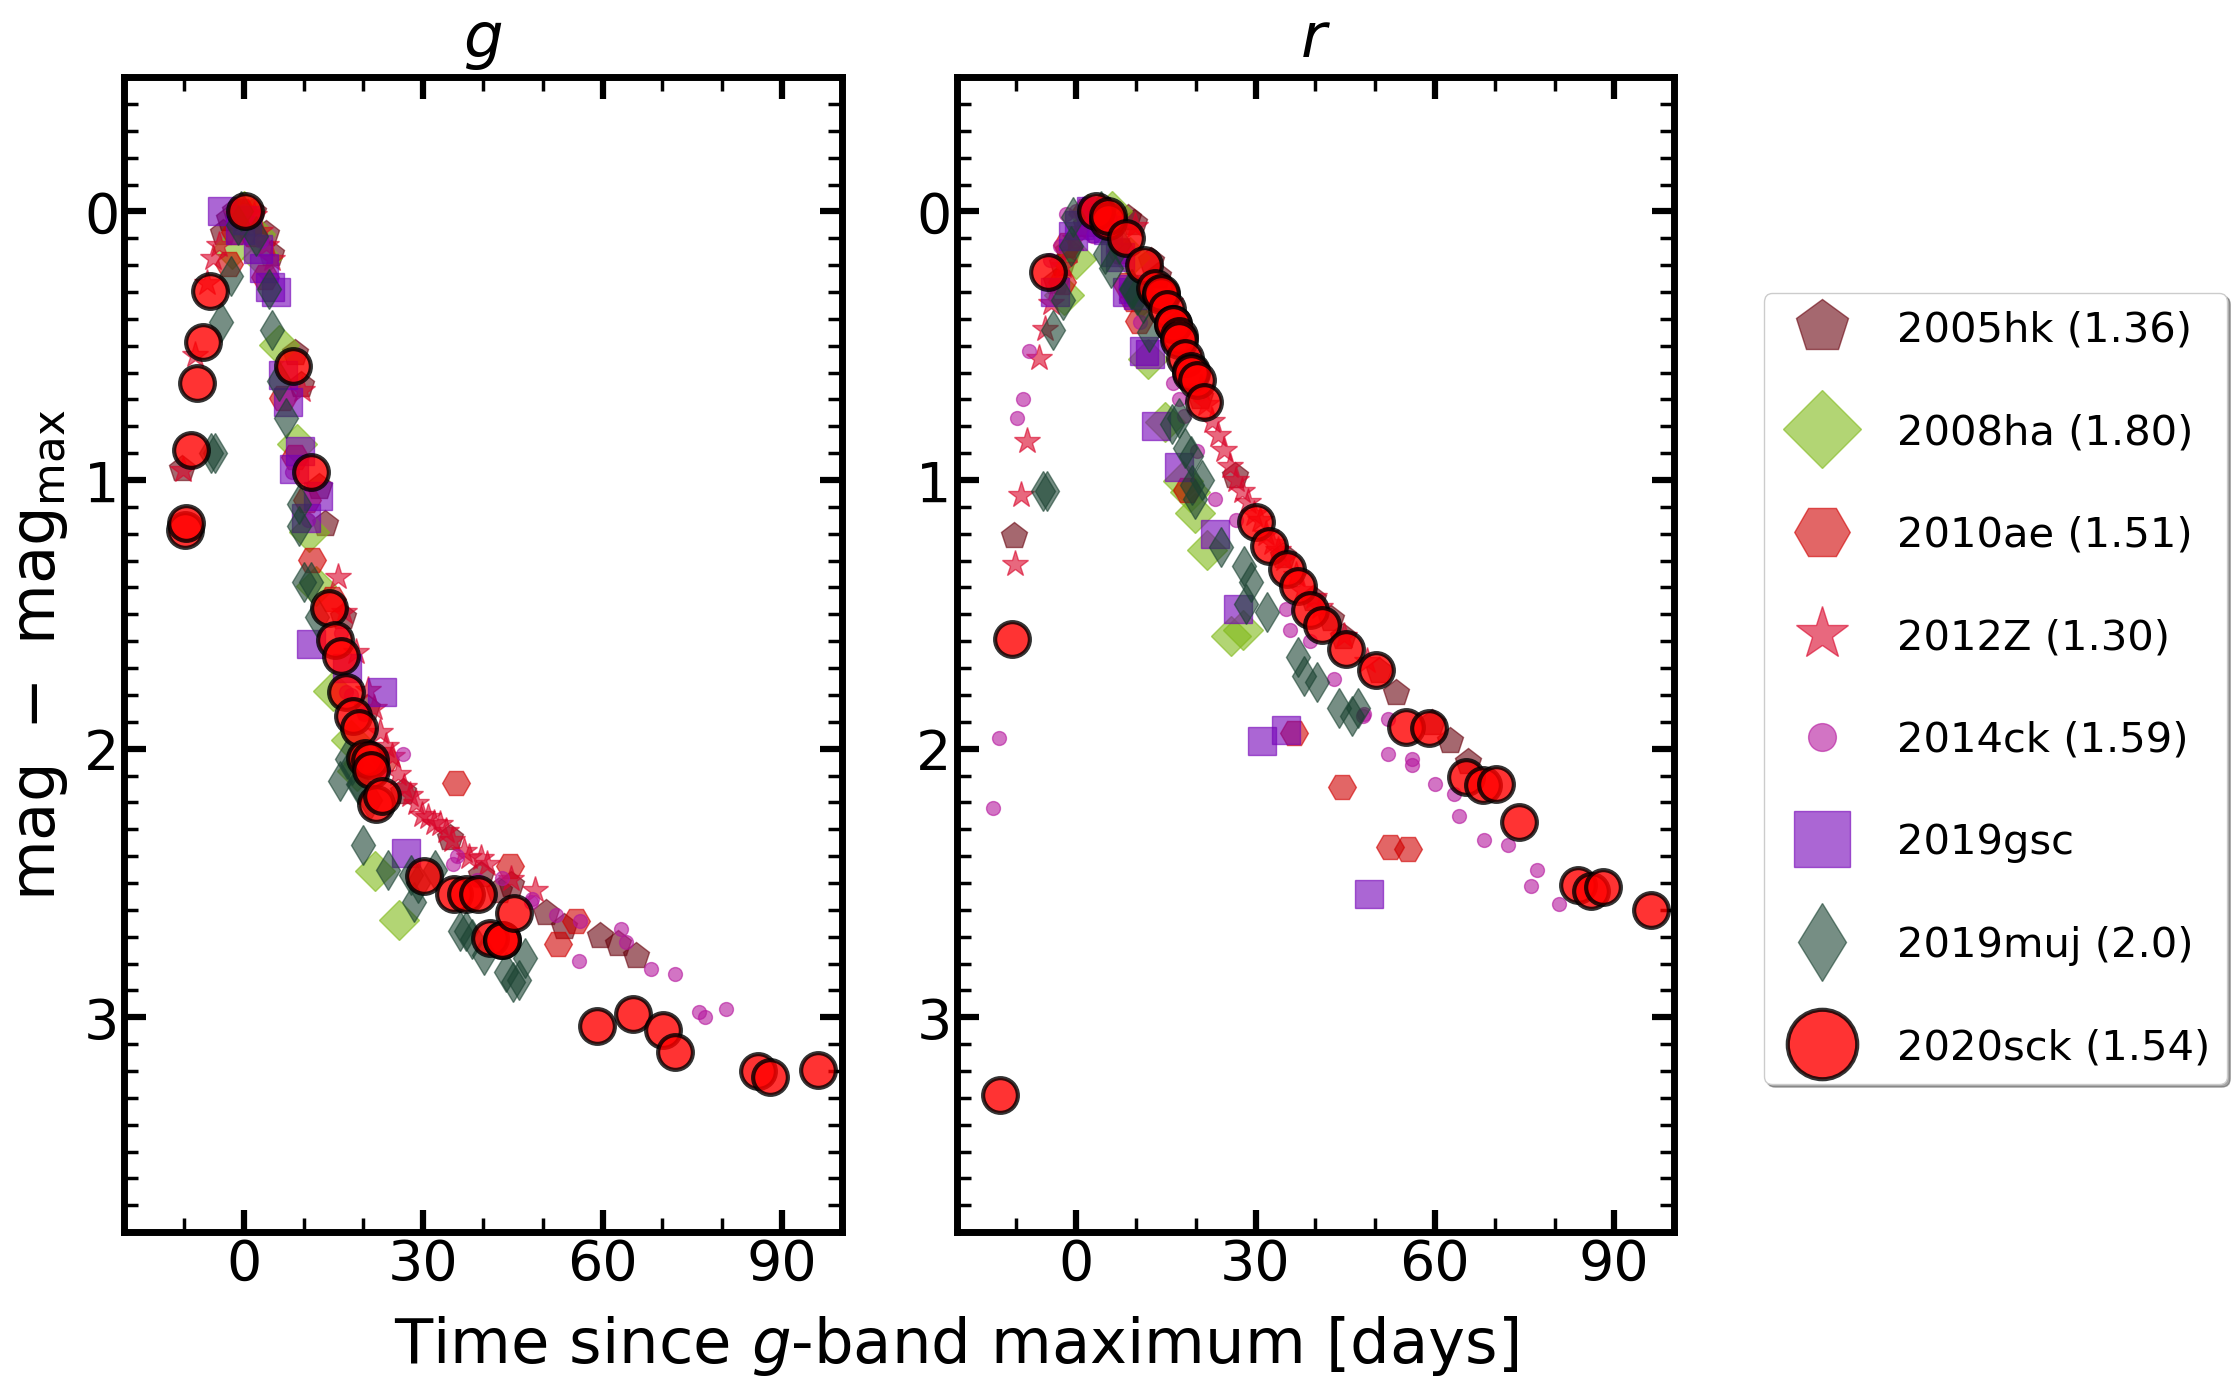

In [14]:
def plot_sn_gri_(object_df_gri, savefig=False):
    
    list_files = group_similar_files('', gri_directory+'/*.asc')
    #print (list_files)
    fig_app = plt.figure(figsize=(20, 15))
    plt.rcParams['axes.linewidth'] = 5
    fig_app.subplots_adjust(hspace=0.15, wspace=0.16)
    legend_properties = {'size': 30, 'weight': 'book'}
    
    filters = ['g', 'r']
    
    for i, j in enumerate(filters, 1):
        ax = fig_app.add_subplot(1, 2, i)
        ax.set_xlim(-20,100)
        ax.set_ylim(-0.5, 3.8)
        if j == 'g':
            ax.set_ylabel(r'$\rm mag\ -\ mag_{max}$', fontsize = 45, labelpad=10)

        plot_params('A', ax, ml_x = 20, mil_x = 5, ml_y = 1, mil_y = 0.1, invert=True)
        ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 16, width = 4.5, labelsize = 20)
        ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 10, width = 2.5, labelsize = 20)
        ax.xaxis.set_major_locator(MultipleLocator(30))
        ax.xaxis.set_minor_locator(MultipleLocator(10))
        sn_df = object_df_gri[object_df_gri['FILTER'] == j].copy()
        sn_df = sn_df.sort_values(by = 'Phase')
        #print (sn_df)
        
        ax.set_title(r'$%s$'%j, fontsize = 45, pad=15.0)
    
        for file_name in list_files:
            name = file_name.split('/')[-1].split('.')[0]
            #print (name)
            if name in ['2005hk', '2008ha', '2010ae', '2012Z', '2014ck', '2019gsc', '2019muj']:
                data_df = pd.read_csv(file_name, sep = '\s+', comment = '#', engine = 'python')
                #print (data_df)
                if 'FMAG' not in data_df.columns.values:
                #data_df['Phase'] = data_df['JD'] - SNdata_df.loc[name, 'B_maximum']
                    data_df = columnwise_to_rowwise1(name, data_df)
                    #data_df.to_csv('/home/anirban/Desktop/SNIa_sample/LC_Data/Save_mlcs/'+name+'.dat', sep=' ', 
                    #          index=True, index_label='FILTER')
                    #print (data_df)
                    df = data_df[data_df['FILTER'] == j].copy()
                    df = df.sort_values(by = 'Phase')
                    df.Phase = pd.to_numeric(df.Phase)
                    df.FMAG = pd.to_numeric(df.FMAG)
                    #print (df)
                    if name == '2012fr':
                        df['Norm_Mag'] = df['FMAG']- dict_maxmag_12fr[j]
                    else:
                        df['Norm_Mag'] = df['FMAG']- df['FMAG'].min()
                    if name != '2019gsc':
                        ax.plot(df['Phase'], df['Norm_Mag'], marker = gri_df.loc[name, 'Marker'],
                            label = name+' '+'('+str(gri_df.loc[name, 'delta_mg'])+')',
                            c = gri_df.loc[name, 'Color'], alpha = 0.6, ls = '', ms=20)
                    else:
                        ax.plot(df['Phase'], df['Norm_Mag'], marker = gri_df.loc[name, 'Marker'],
                            label = name, c = gri_df.loc[name, 'Color'], alpha = 0.6, ls = '', ms=20)
                    #ax.plot(df['Phase'], df['Norm_Mag'], marker='+')
                else:
                    data_df['Phase'] = data_df['JD'] - gri_df.loc[name, 'g_maximum']
                    df = data_df[data_df['FILTER'] == j].copy()
                    df = df.sort_values(by = 'Phase')
                    df.Phase = pd.to_numeric(df.Phase)
                    df.FMAG = pd.to_numeric(df.FMAG)
                    ax.plot(df['Phase'], df['FMAG']-df['FMAG'].min(), marker = gri_df.loc[name, 'Marker'], label = name, c = gri_df.loc[name, 'Color'],
                       alpha = 0.8, ls = '')
            for tick in ax.xaxis.get_major_ticks():
                tick.label1.set_fontsize(fontsize = 40)
                #tick.label1.set_fontweight('bold')
    
            for tick in ax.yaxis.get_major_ticks():
                tick.label1.set_fontsize(fontsize = 40)
                #tick.label1.set_fontweight('bold')    
                
                
        ax.plot(sn_df['Phase'], sn_df['FMAG']-sn_df['FMAG'].min(), label = '2020sck (1.54)', mfc='red', ms = 25, 
                alpha = 0.8, ls = '', marker = 'o', markeredgecolor='black', markeredgewidth=3.0)
    #ax.legend(fontsize = 20, prop = legend_properties, loc = 'best')
    ax.legend(loc='lower right', bbox_to_anchor=(1.8, 0.11),
                  ncol=1, fancybox=True, shadow=True, fontsize = 30, prop = legend_properties,
             markerscale=2.0, labelspacing=1.5)
    ax.set_xlabel('Time since $g$-band maximum [days]', fontsize = 45, labelpad=7)
    ax.xaxis.set_label_coords(0.00, -0.07)
    #
    if savefig:
        plt.savefig('/home/anirban/2020sck/Results/New_Results/Results/Plots/Comparison_2020sck_gri.png', 
                    dpi=100, bbox_inches = 'tight', transparent=False, facecolor='white')
        
        
plot_sn_gri_(ztf_lc_df, savefig=False)     
plt.show();
#print (data_df_hk)

In [30]:
def jd_to_date(jd, input_fmt='jd', output_fmt='isot'):
    
    '''
    Remarks: Convert jd to date
    jd: Input jd
    input_fmt: format of input ('jd')
    output_fmt: format of output ('iso', 'isot')
    returns: date
    '''
    
    from astropy.time import Time
    times = Time(jd, format=input_fmt)
    date_time = times.to_value(output_fmt)
    date = date_time.split('T')[0]
    
    return date


def find_local_minima(arr, n):
    
    '''
    Remarks: Finds the minima
    arr: array to be used as input.
    n: length of the array.
    
    returns: index of minima
    '''
    
    idx_min = []
    if (arr[0] < arr[1]):
        idx_min.append(0)
    for i in range(1, n-1):
        if (arr[i-1] > arr[i] < arr[i+1]):
            idx_min.append(i)
    if (arr[-1] < arr[-2]):
        idx_min.append(n-1)
        
    return idx_min

def remove_outliers(list_, z=3):
    
    '''
    Remarks: Remove outliers from a list based on z-score
    list_: Input list
    z: z-score 
    returns: new_list removing outliers
    '''
    mean = np.mean(list_)
    std = np.std(list_)
    new_list = []
    [new_list.append(i) for i in list_ if abs(i-mean)/std < z]
    
    return new_list

def iterate_outliers(list_, iterations=3):
    
    '''
    Remarks: Iterate over lists to remove outliers. Calls remove_outliers function
    list_: Input list
    iterations: No of iterations to performed, default=3
    returns: new_list removing outliers.
    '''
    new_list = list_[:]
    for i in range(iterations):
        new_list = remove_outliers(new_list)

    return new_list



def interpolate_lc(df, band, amp=None, scale=None, diff_deg=None,
                  plot=False, save_pred=False):
    
    '''
    Remarks: Interpolate Light Curve with Gaussian Process
    Regression.
    df: SN LC dataframe
    band: Filter 
    amp: amplitude of kernel (typically set by the amount by which the function
    varies.default is set by the standard deviation of the magnitude.)
    scale: scale over which the function typically varies.(default is 10)
    diff_deg: degree of differentiability. Controls the smoothness of the function.
    plot: Bool to plot the results
    save_pred: Bool to save the predictions as pickle file for later use.
    
    returns: LC parameters after fit
    (jd, magnitude, magnitude_err) at maximum.
    
    
    '''
    
    band_df = df[df['FILTER']==band].copy()
    
    x = np.ravel(band_df['JD'].values)    # x-value
    y = np.ravel(band_df['FMAG'].values)  # y-value
    yerr = np.ravel(band_df['FERR'].values) # error on y value
    
    mean = lambda x: x*0 + np.median(y)  # construction of the mean function
    
    if amp is None:
        amp = np.std(y - mean(x))
    elif amp == 'LC':
        amp = np.std(y)
    if scale is None:
        scale = 10
    if diff_deg is None:
        diff_deg = 1
        
    # Define the kernel
    # A constant kernel plus the matern kernel
    
    kernel = ConstantKernel(amp, constant_value_bounds='fixed') * \
             Matern(length_scale=scale, length_scale_bounds='fixed', nu=diff_deg+0.5)
    
    # Implement Gaussian Process Regressor
    gp = GaussianProcessRegressor(kernel=kernel, alpha=yerr**2)
    # Fit the gp model
    X = np.array([x]).T
    Y = y - mean(x)    # residual
    gauss_process = gp.fit(X, Y)
    
    ## Make predictions at points
    list_jd = np.atleast_2d(np.linspace(band_df['JD'].min()-8, band_df['JD'].max(), 1000)).T
    
    ## Make predictions
    x_pred = np.ravel(list_jd)
    res, sig_pred = gp.predict(list_jd, return_std=True)
    res += mean(x_pred)
    
    # Calculate the maxima of the LC and the jd for the maxima.
    n = len(res)
    idx_minima = find_local_minima(res, n)
    
    ## I-band will have a secondary maxima
    ## Need to modify this part of the code in an optimum way.
    if band != 'I':
        jd_max = x_pred[idx_minima[0]]
        mag_max = res[idx_minima[0]]
        err_max = sig_pred[idx_minima[0]]
        jd_15 = jd_max + 15
        res_15, err_15 = gp.predict(np.atleast_2d(jd_15).T, return_std=True)
        mag_15 = res_15 + mean(jd_15)
        dm15 = mag_15 - mag_max
        dm15_err = np.sqrt(err_max**2 + err_15**2)
    else:
        jd_max = x_pred[idx_minima[0]]
        mag_max = res[idx_minima[0]]
        print (mag_max)
        err_max = sig_pred[idx_minima[0]]
        jd_15 = jd_max + 15
        res_15, err_15 = gp.predict(np.atleast_2d(jd_15).T, return_std=True)
        mag_15 = res_15 + mean(jd_15)
        dm15 = mag_15 - mag_max
        dm15_err = np.sqrt(err_max**2 + err_15**2)
        
        #jd_max2 = x_pred[idx_minima[1]]
        #mag_max2 = res[idx_minima[1]]
        #err_max2 = sig_pred[idx_minima[1]]  
    
    ## Make plots of predictions and show confidence intervals
    if plot:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111)
        ax.invert_yaxis()
        
        ax.plot(x_pred, res, 'k-', label='Prediction')
        ax.errorbar(x, y, yerr, fmt='r.', ms=10, 
                    label='Observation')
        if band !='I':
            ax.plot(jd_max, mag_max, '*', color='orange', ms=12)
        else:
            ax.plot(jd_max, mag_max, '*', color='orange', ms=12)
            print (mag_max)
            #ax.plot(jd_max2, mag_max2, '*', color='orange', ms=12)
        ax.fill_between(x_pred, res-sig_pred, res+sig_pred,
               alpha = 0.3, fc = 'teal', ec='None', label = '1-sigma')
        
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize = 15)
            #tick.label1.set_fontweight('bold')
    
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize = 15)
            #tick.label1.set_fontweight('bold')
        ax.legend()
        
    # Save the predictions as pickle file
    if save_pred:
        interp_df = pd.DataFrame(list(zip(x_pred, res, sig_pred)), columns=['JD', 'FMAG', 'FERR'])
        output_filename = save_results+'interp_'+str(band)+'.pkl'
        if os.path.exists(output_filename):
            os.remove(output_filename)
        interp_df.to_pickle(output_filename)
        
    if band != 'I':
        return (x_pred, res, sig_pred, jd_max, mag_max, err_max, jd_15, 
                mag_15, err_15, dm15, dm15_err)
    else:
        return (x_pred, res, sig_pred, jd_max, mag_max, err_max, 
                jd_15, mag_15, err_15, dm15, dm15_err)
        
        
def gp_fit(df, x, y, yerr, band, amp=None, scale=None, diff_deg=None):
    
    '''
    Remarks: Interpolate Light Curve with Gaussian Process
    Regression.
    df: SN LC dataframe
    x, y, yerr: the observed data array. 
    band: Filter 
    amp: amplitude of kernel (typically set by the amount by which the function
    varies.default is set by the standard deviation of the magnitude.)
    scale: scale over which the function typically varies.(default is 10)
    diff_deg: degree of differentiability. Controls the smoothness of the function.
    
    returns: jd at maximum.
    
    
    
    '''
    
    band_df = df[df['FILTER']==band].copy()
    mean = lambda x: x*0 + np.median(y)
    
    if amp is None:
        amp = np.std(y - mean(x))
    elif amp == 'LC':
        amp = np.std(y)
    if scale is None:
        scale = 10
    if diff_deg is None:
        diff_deg = 1
    
    kernel = ConstantKernel(amp, constant_value_bounds='fixed') * Matern(length_scale=scale,
                                                                        length_scale_bounds='fixed',
                                                                         nu=diff_deg+0.5)
    
    gp = GaussianProcessRegressor(kernel=kernel, alpha=yerr**2)
    X = np.array([x]).T
    Y = y - mean(x)
    gauss_process = gp.fit(X, Y)
    
    ## Make predictions at points
    list_jd = np.atleast_2d(np.linspace(band_df['JD'].min()-8, band_df['JD'].max(), 1000)).T
    
    ## Make predictions
    x_pred = np.ravel(list_jd)
    res, sig_pred = gp.predict(list_jd, return_std=True)
    res += mean(x_pred)
    
    n = len(res)
    idx_minima = find_local_minima(res, n)
    if band != 'I':
        jd_max = x_pred[idx_minima[0]]
    else:
        jd_max = x_pred[idx_minima[0]]
        #jd_max2 = x_pred[idx_minima[1]]
        
    if band != 'I':
        return jd_max
    else:
        return jd_max
    
def monte_carlo(df, mc_trials, band, store_params=True, kcorr=False):
    
    '''
    df: SN LC dataframe
    mc_trials: no of monte carlo realizations of the covariance of the LC
    band: Filter
    store_params: Bool to store parameters in a text file
    kcorr: Bool to store k-corr or not.
    
    returns: None
    '''
    
    band_df = df[df['FILTER']==band].copy()
    x = np.ravel(band_df['JD'].values)
    y = np.ravel(band_df['FMAG'].values)
    yerr = np.ravel(band_df['FERR'].values)
    
    param_value = interpolate_lc(df, band, amp=None, scale=30, diff_deg=2,
                                    plot=False, save_pred=False)
    
    if band != 'I':
        x_pred = param_value[0]
        res = param_value[1]
        sig_pred = param_value[2]
        jd_max = param_value[3]
        mag_max = param_value[4]
        err_max = param_value[5]
        jd_15 = param_value[6]
        mag_15 = param_value[7]
        err_15 = param_value[8]
        dm15 = param_value[9]
        dm15_err = param_value[10]
    else:
        x_pred = param_value[0]
        res = param_value[1]
        sig_pred = param_value[2]
        jd_max = param_value[3]
        mag_max = param_value[4]
        err_max = param_value[5]
        #jd_max2 = param_value[6]
        #mag_max2 = param_value[7]
        #err_max2 = param_value[8]
        jd_15 = param_value[6]
        mag_15 = param_value[7]
        err_15 = param_value[8]
        dm15 = param_value[9]
        dm15_err = param_value[10]
        
    jd_max_list = []
    #jd_max2_list = []
    np.random.seed(143)
    for trails in range(mc_trials):
        y_err = np.random.normal(scale=yerr, size=np.size(y))
        if band != 'I':
            jd_max_list.append(gp_fit(df, x, y, y_err, band, scale=30, diff_deg=2))
        else:
            jd_max_list.append(gp_fit(df, x, y, y_err, band, scale=30, diff_deg=2))
            #jd_max2_list.append(gp_fit(df, x, y, y_err, band, scale=30, diff_deg=2)[1])
        
    if band != 'I':
        jd_ = iterate_outliers(remove_outliers(jd_max_list))
        jd_max_err = np.std(jd_)
    else:
        jd_ = iterate_outliers(remove_outliers(jd_max_list))
        jd_max_err = np.std(jd_)
        #jd2_ = iterate_outliers(remove_outliers(jd_max2_list))
        #jd_max2_err = np.std(jd2_)
        
    if store_params:
        
        file_name = save_results+'Params_'+str(band)+'.txt'
        if os.path.exists(file_name):
            os.remove(file_name)
        f = open(file_name, 'w')
        f.write('This file contains the LC params of %s in filter-%s\n\n'%(OBJECT, band))
        f.write("#-----------------------------#\n\n")
        f.write("#-----------------------------#\n")
        f.write("Jd at maximum in %s band is: %f +/- %f\n" %(band, jd_max, jd_max_err))
        f.write("Magnitude at maximum in %s band is: %f +/- %f\n" %(band, mag_max, err_max))
        f.write("#-----------------------------#\n")
        f.write("#-----------------------------#\n")
        f.write("JD after 15-days from %s band maximum is: %f\n" %(band, jd_15))
        f.write("Magnitude after 15-days from %s band maximum is: %f +/- %f\n" %(band, mag_15, err_15))
        f.write("Estimated value of dm15 is: %f +/- %f\n" %(dm15, dm15_err))
        if band != 'I':
            f.write("Secondary maximum is not applicable for this band\n")
        else:
            f.write("The values for the secondary maxima are\n")
            #f.write("#-----------------------------#\n")
            #f.write("JD for secondary maxima for %s band is: %f+/-%f\n" %(band, jd_max2, jd_max2_err))
            #f.write("Magnitude for secondary maxima for %s band is: %f +/- %f\n" %(band, mag_max2, err_max2))
            #f.write("#-----------------------------#\n")
        
        if not kcorr:
            f.write("The magnitudes are not k-corrected\n")
            
        f.write("Interpolated Light Curve through GP\n\n")
        f.write("#-----------------------------#\n\n")
        f.write("{0:>4s}{1:>20s}{2:>15s}\n\n".format('JD', 'MAG', 'MERR'))
        for l in zip(x_pred, res, sig_pred):
            f.write("{0:>4f}{1:>20f}{2:>15f}\n\n".format(*l))
        
        
        f.close()

59099.13929547677


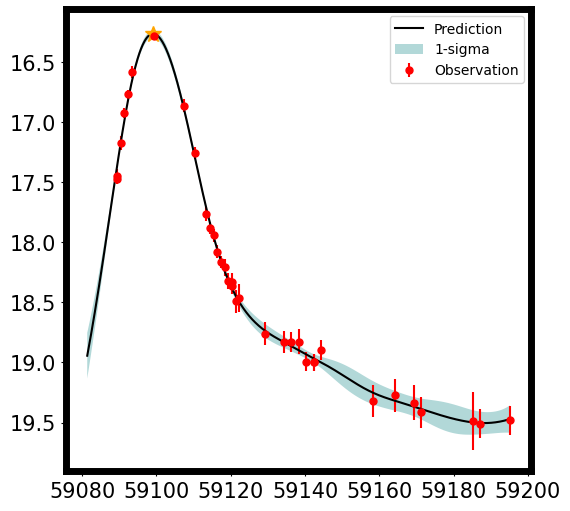

In [35]:
interp_values = interpolate_lc(ztf_lc_df, band='g', amp = None, scale=30, diff_deg=2, plot=True,
              save_pred=False)
print (interp_values[3])

plt.show();

In [36]:
monte_carlo(object_df_UBVRI, mc_trials=100, band='V', store_params=True, kcorr=False)

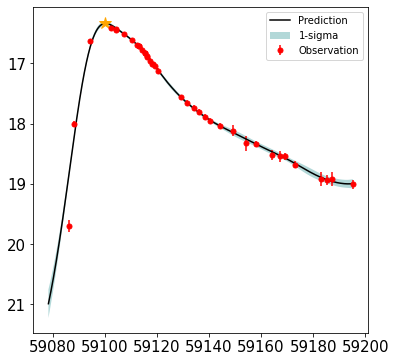

In [28]:
interp_values = interpolate_lc(ztf_lc_df, band='r', amp = None, scale=30, diff_deg=2, plot=True,
              save_pred=False)

In [36]:
object_df_UBVRI

JD FILTER    FMAG   FERR   Phase
0   2459093.382      B  16.787  0.039  -8.042
1   2459094.231      B  16.784  0.070  -7.193
2   2459095.307      B  16.614  0.040  -6.117
3   2459100.336      B  16.517  0.042  -1.088
4   2459101.424      B  16.587  0.037   0.000
5   2459102.437      B  16.707  0.038   1.013
6   2459104.419      B  16.818  0.041   2.995
7   2459106.458      B  17.173  0.047   5.034
8   2459110.433      B  17.817  0.066   9.009
9   2459113.208      B  18.555  0.087  11.784
10  2459114.414      B  18.721  0.094  12.990
11  2459117.243      B  19.247  0.122  15.819
12  2459093.370      I  16.700  0.034  -8.054
13  2459094.221      I  16.719  0.039  -7.203
14  2459095.302      I  16.498  0.035  -6.122
15  2459100.331      I  16.326  0.031  -1.093
16  2459101.420      I  16.261  0.029  -0.004
17  2459102.432      I  16.283  0.031   1.008
18  2459104.413      I  16.292  0.031   2.989
19  2459106.449      I  16.185  0.028   5.025
20  2459110.428      I  16.341  0.029   9.004
21  2459113.203      I  16.347  0.029  11.779
22  2459114.221      I  16.422  0.032  12.797
23  2459117.238      I  16.465  0.033  15.814
24  2459120.328      I  16.591  0.034  18.904
25  2459122.316      I  16.706  0.030  20.892
26  2459126.284      I  16.816  0.039  24.860
27  2459148.216      I  17.615  0.048  46.792
28  2459167.090      I  17.986  0.057  65.666
29  2459093.372      R  16.744  0.031  -8.052
30  2459094.217      R  16.659  0.036  -7.207
31  2459095.300      R  16.532  0.032  -6.124
32  2459100.329      R  16.337  0.031  -1.095
33  2459101.418      R  16.321  0.029  -0.006
34  2459102.430      R  16.404  0.026   1.006
35  2459104.411      R  16.404  0.028   2.987
36  2459106.453      R  16.471  0.029   5.029
37  2459110.426      R  16.578  0.028   9.002
38  2459113.202      R  16.623  0.030  11.778
39  2459114.220      R  16.689  0.033  12.796
40  2459117.236      R  16.798  0.036  15.812
41  2459120.325      R  16.997  0.035  18.901
42  2459122.313      R  17.094  0.033  20.889
43  2459148.214      R  17.968  0.051  46.790
44  2459167.087      R  18.322  0.060  65.663
45  2459093.389      U  16.028  0.104  -8.035
46  2459094.241      U  15.941  0.155  -7.183
47  2459095.311      U  15.891  0.104  -6.113
48  2459100.339      U  15.926  0.104  -1.085
49  2459101.428      U  15.994  0.083   0.004
50  2459102.442      U  15.968  0.120   1.018
51  2459104.425      U  16.120  0.130   3.001
52  2459106.462      U  16.271  0.122   5.038
53  2459110.437      U  16.524  0.092   9.013
54  2459113.212      U  17.243  0.112  11.788
55  2459114.418      U  17.538  0.105  12.994
56  2459093.377      V  16.792  0.031  -8.047
57  2459094.225      V  16.721  0.037  -7.199
58  2459095.304      V  16.625  0.035  -6.120
59  2459100.333      V  16.386  0.030  -1.091
60  2459101.422      V  16.363  0.026  -0.002
61  2459102.434      V  16.438  0.032   1.010
62  2459104.416      V  16.549  0.032   2.992
63  2459106.455      V  16.620  0.036   5.031
64  2459110.430      V  16.862  0.034   9.006
65  2459113.206      V  16.998  0.036  11.782
66  2459114.223      V  17.108  0.036  12.799
67  2459117.240      V  17.302  0.040  15.816
68  2459120.330      V  17.494  0.045  18.906
69  2459122.323      V  17.646  0.044  20.899
70  2459138.448      V  18.139  0.057  37.024
71  2459148.219      V  18.372  0.059  46.795
72  2459167.092      V  18.629  0.067  65.668